In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42651")
client

<Client: 'tcp://127.0.0.1:42651' processes=8 threads=40, memory=157.39 GiB>

In [26]:
client.restart()

Connection method: Direct,
Dashboard: http://127.0.0.1:8787/status,
Comm: tcp://127.0.0.1:42651,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 1 hour ago,Total memory: 0 B


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# from dask.diagnostics import ProgressBar
import os.path as op
import os
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib
matplotlib.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 25
yend = 50

Nyears = 50

xchunk = 100
ychunk = 101
schunk = 5
membchunk = 1
dnf = 2160
nfile = 73

In [5]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,1967)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=1421280,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(yNstart-12**-1,yend+2*12**-1),
                          YG=slice(yNstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 303, XG: 1000, YG: 303, Z: 46, Zp1: 47, Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 24.92 25.0 25.08 25.17 25.25 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 24.96 25.04 25.13 25.21 25.29 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 101, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 101, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [27]:
ntimes = np.arange(1421280,1576800+dnf,dnf)
# nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
nmembs = np.concatenate((np.arange(24),np.arange(36,48)))
year = 1967
nstart = 0
print(ntimes[nstart])

1421280


In [30]:
ystart = yNstart

for itime in ntimes[:1]:
#         if itime == ntimes[0,0]:
#         else:
#             ystart = yNstart
        
    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                 % (0,1967)), 
                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                         iters=itime,
                         prefix=['diag_ocnTave'], delta_t=2e2,
                        ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                              YG=slice(ystart-12**-1,yend+2*12**-1)
                             ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                   'YC':ychunk,'YG':ychunk})
        
    ds5 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    delta = .5*(ds5.delta_outer[1:].data 
                    + ds5.delta_outer[:-1].data)
    ds5.coords['delta'] = ('delta',delta)
    zetab = ds5.zetab
    zetaxb = ds5.zetaxb
    zetayb = ds5.zetayb
    dzetab = ds5.dzetab.where(ds5.dzetab!=0.)
    dzetaxb = ds5.dzetaxb.where(ds5.dzetaxb!=0.)
    dzetayb = ds5.dzetayb.where(ds5.dzetayb!=0.)
        
    ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1),
                            nmemb=np.arange(36)
#                             nmemb=np.concatenate((np.arange(12),np.arange(24,36)))
                           ).reset_coords(drop=True)
    ds6 = ds6.drop_vars('nmemb')
    ds6.coords['nmemb'] = ('nmemb',nmembs)
    ds6.coords['delta'] = ('delta',delta)
    upp = ds6.upp
    vpp = ds6.vpp
    varpipp = ds6.varpipp
    zetap = ds6.zetap
    zetayp = ds6.zetayp
    zetaxp = ds6.zetaxp
    mbyp = ds6.mbyp
    mbxp = ds6.mbxp
       
    ds7 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    ds7.coords['delta'] = ('delta',delta)
    uhat = ds7.uhat
    vhat = ds7.vhat
    varpihat = ds7.varpihat
            
    for imemb in nmembs:
            
        if imemb == 0:
            ds1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                       % (year,imemb,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                    YG=slice(ystart-12**-1,yend+2*12**-1)
                                   ).isel(time=0).reset_coords(drop=True)
            ds3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/'
                                       % (year,imemb,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                    YG=slice(ystart-12**-1,yend+2*12**-1)
                                   ).isel(time=0).reset_coords(drop=True)
            ds4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                       % (year,imemb,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                   ).isel(time=0).reset_coords(drop=True)
                
        else:
            tmp1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                        % (year,imemb,itime))
                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                     YG=slice(ystart-12**-1,yend+2*12**-1)
                                    ).isel(time=0).reset_coords(drop=True)
            ds1 = xr.concat([ds1,tmp1], 'nmemb')
            tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/' 
                                        % (year,imemb,itime))
                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                     YG=slice(ystart-12**-1,yend+2*12**-1)
                                    ).isel(time=0).reset_coords(drop=True)
            ds3 = xr.concat([ds3,tmp3], 'nmemb')
            tmp4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                        % (year,imemb,itime))
                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                    ).isel(time=0).reset_coords(drop=True)
            ds4 = xr.concat([ds4,tmp4], 'nmemb')
        
    ds1.coords['nmemb'] = ('nmemb',nmembs)
    ds3.coords['nmemb'] = ('nmemb',nmembs)
    ds4.coords['nmemb'] = ('nmemb',nmembs)
#         ds5.coords['nmemb'] = ('nmemb',range(48))
        
    buoyb = -grav * ds5.delta * rhoConst**-1
    buoybp1 = -grav * ds5.delta_outer * rhoConst**-1
        
    grid = Grid(ds5, periodic=['X'], 
                    coords={'Z':{'center':'delta','outer':'delta_outer'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )
        
    sigmab = (dzetab * -grid.diff(buoyb,'Z',boundary='extend')**-1)
    sigmaxb = (dzetaxb * -grid.diff(buoyb,'Z',boundary='extend')**-1)
    sigmayb = (dzetayb * -grid.diff(buoyb,'Z',boundary='extend')**-1)

###############################
    dzetaF = ds1.dzetaF.where(ds1.dzetaF!=0.)
    dzetaFy = ds1.dzetaFy.where(ds1.dzetaFy!=0.)
    dzetaFx = ds1.dzetaFx.where(ds1.dzetaFx!=0.)
    sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='extend')**-1
    sigmay = xr.DataArray(dzetaFy.data, 
                          dims=['nmemb','YG','XC','delta_outer'],
                          coords={'nmemb':ds1.nmemb.data,
                                  'YG':ds.YG.data,'XC':ds.XC.data,
                                  'delta_outer':ds5.delta_outer.data}
                 ) * -grid.diff(buoyb,'Z',boundary='extend')**-1
    sigmax = xr.DataArray(dzetaFx.data, 
                          dims=['nmemb','YC','XG','delta_outer'],
                          coords={'nmemb':ds1.nmemb.data,
                                  'YC':ds.YC.data,'XG':ds.XG.data,
                                  'delta_outer':ds5.delta_outer.data}
                 ) * -grid.diff(buoyb,'Z',boundary='extend')**-1

############################### 
    tmp00_0 = (upp**2*sigmax)
    tmp00_1 = .5*(zetaxp**2)

    tmp11_0 = (vpp**2*sigmay)
    tmp11_1 = .5*(zetayp**2)
    tmp01 = (grid.interp(grid.interp(vpp,'X'),'Y',boundary='fill')
             * upp*sigmax
            )
    tmp10 = (grid.interp(grid.interp(upp,'X'),'Y',boundary='fill') 
             * vpp*sigmay
            )

    tmp20_0 = (varpipp*grid.interp(upp,'X')
               * sigma
              )
    tmp20_1 = grid.interp(mbxp*zetaxp,'X')
    tmp21_0 = (varpipp*grid.interp(vpp,'Y',boundary='fill')
               * sigma
              )
    tmp21_1 = grid.interp(mbyp*zetayp,'Y',boundary='fill')

        
###############################  
    sig_e00_x = (grid.diff(tmp00_0*ds.dyG,'X') * ds.rA**-1
                 + grid.diff(tmp00_1,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1
                )
    sig_e10_y = grid.diff(tmp10*ds.dxG,'Y',boundary='fill') * ds.rA**-1 

    sig_e01_x = grid.diff(tmp01*ds.dyG,'X') * ds.rA**-1 
    sig_e11_y = (grid.diff(tmp11_0*ds.dxG,'Y',boundary='fill') * ds.rA**-1
                 + grid.diff(tmp11_1,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
                )
    
    sig_e20_0b = grid.interp(grid.diff(tmp20_0,'Z',boundary='fill') 
                             * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                             'Z',boundary='fill'
                            )
    sig_e20_1b = grid.interp(grid.diff(tmp20_1,'Z',boundary='fill') 
                             * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                             'Z',boundary='fill'
                            )
    sig_e20_b = sig_e20_0b + sig_e20_1b
    
    sig_e21_0b = grid.interp(grid.diff(tmp21_0,'Z',boundary='fill') 
                             * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                             'Z',boundary='fill'
                            )
    sig_e21_1b = grid.interp(grid.diff(tmp21_1,'Z',boundary='fill') 
                             * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                             'Z',boundary='fill'
                            )
    sig_e21_b = sig_e21_0b + sig_e21_1b


    dsave = sig_e00_x.std('nmemb',skipna=True,ddof=1).to_dataset(name='e00x')
    dsave['e01x'] = sig_e01_x.std('nmemb',skipna=True,ddof=1)
    dsave['e10y'] = sig_e10_y.std('nmemb',skipna=True,ddof=1)
    dsave['e11y'] = sig_e11_y.std('nmemb',skipna=True,ddof=1)
    #     dsave['e20b'] = e20_0b + e20_1b
    #     dsave['e21b'] = e21_0b + e21_1b
    dsave['e20_b'] = sig_e20_0b.std('nmemb',skipna=True,ddof=1)
    dsave['e21_b'] = sig_e21_0b.std('nmemb',skipna=True,ddof=1)
    dsave = dsave.reset_coords(drop=True)

    if itime == ntimes[nstart+1]:
        print(dsave)
    #     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
    #                             % (year,nremap,itime)), mode='w')
    chunks = {'XC':xchunk,'YC':ychunk,'delta_outer':-1}
    dsave.chunk(chunks).to_zarr(op.join(tdgs,'5Dave/run%4d/stdDivE-P/%2dmembs/%010d/' 
                                            % (year,
                                               len(nmembs),
                                               itime)), mode='w')
    dsave.close()


    del tmp00_0, tmp00_1, tmp11_0, tmp11_1
    del tmp01, tmp10
    del tmp20_0, tmp20_1, tmp21_0, tmp21_1
    del sigma
    ds.close()
    ds1.close()
    ds3.close()
    ds4.close()
    ds5.close()
    ds6.close()
    ds7.close()
    print(itime)
        
    # client.restart()

/tmp/ipykernel_10227/2508839275.py:18: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds5 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/'
/tmp/ipykernel_10227/2508839275.py:33: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=Fals

1421280


In [33]:
ystart = yNstart

for itime in ntimes[:1]:

    if itime == ntimes[0]:
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (0,1967)), 
                                 grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                 iters=itime,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1)
                                     ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                           'YC':ychunk,'YG':ychunk})

        ds5 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                                   % (year,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                    YG=slice(ystart-12**-1,yend+2*12**-1)
                                   ).reset_coords(drop=True)
        ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/stdDivE-P/%2dmembs/%010d/' 
                                   % (year,
                                      len(nmembs),
                                      itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
    else:
        ds5 = xr.concat([ds5, xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                                                   % (year,itime))
                                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                    YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).reset_coords(drop=True)
                        ], 'time')
        ds6 = xr.concat([ds6, xr.open_zarr(op.join(tdgs,'5Dave/run%4d/stdDivE-P/%2dmembs/%010d/' 
                                                   % (year,
                                                      len(nmembs),
                                                      itime))
                                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).reset_coords(drop=True)
                        ], 'time')
delta = .5*(ds5.delta_outer[1:].data 
            + ds5.delta_outer[:-1].data)
ds5.coords['delta'] = ('delta',delta)
ds6.coords['delta'] = ('delta',delta)
ds6

/tmp/ipykernel_10227/4062978308.py:18: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds5 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/'


<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 303, delta_outer: 55, delta: 54)
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    e00x         (YC, XC, delta_outer) float64 dask.array<chunksize=(101, 100, 55), meta=np.ndarray>
    e01x         (YC, XC, delta_outer) float64 dask.array<chunksize=(101, 100, 55), meta=np.ndarray>
    e10y         (YC, XC, delta_outer) float64 dask.array<chunksize=(101, 100, 55), meta=np.ndarray>
    e11y         (YC, XC, delta_outer) float64 dask.array<chunksize=(101, 100, 55), meta=np.ndarray>
    e20_b        (YC, XC, delta_outer) float64 dask.array<chunksize=(101, 100, 55), meta=np.ndarray>
    e21_b        (YC, XC, delta_outer) float64 dask.array<chunksize=(101, 100, 55), meta=np.ndarray>

In [34]:
dzetab = ds5.dzetab.where(ds5.dzetab!=0.)
buoyb = -grav * ds5.delta * rhoConst**-1
sigmab = (dzetab * -grid.diff(buoyb,'Z',boundary='extend')**-1)

N = len(nmembs)
stdE00x = ds6.e00x / sigmab / (N-1)
stdE01x = ds6.e01x / sigmab / (N-1)
stdE10y = ds6.e10y / sigmab / (N-1)
stdE11y = ds6.e11y / sigmab / (N-1)
stdE20b = ds6.e20_b / sigmab / (N-1)
stdE21b = ds6.e21_b / sigmab / (N-1)
stdE00x

<xarray.DataArray (YC: 303, XC: 1000, delta_outer: 55)>
dask.array<truediv, shape=(303, 1000, 55), dtype=float64, chunksize=(101, 100, 55), chunktype=numpy.ndarray>
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2

In [35]:
nsig = 23
mask = np.ma.masked_invalid(dzetab.sel(YC=slice(ySstart+5-12**-1,
                                                yend+12**-1)
                                      ).isel(delta_outer=nsig)
                           ).mask
mask20 = np.ma.masked_invalid(stdE20b.sel(YC=slice(yNstart-12**-1,
                                                yend+12**-1)
                                      ).isel(delta_outer=nsig)
                           ).mask
mask21 = np.ma.masked_invalid(stdE21b.sel(YC=slice(yNstart-12**-1,
                                                yend+12**-1)
                                      ).isel(delta_outer=nsig)
                           ).mask

In [13]:
zetab = ds5.zetab.where(ds5.dzetab!=0.)

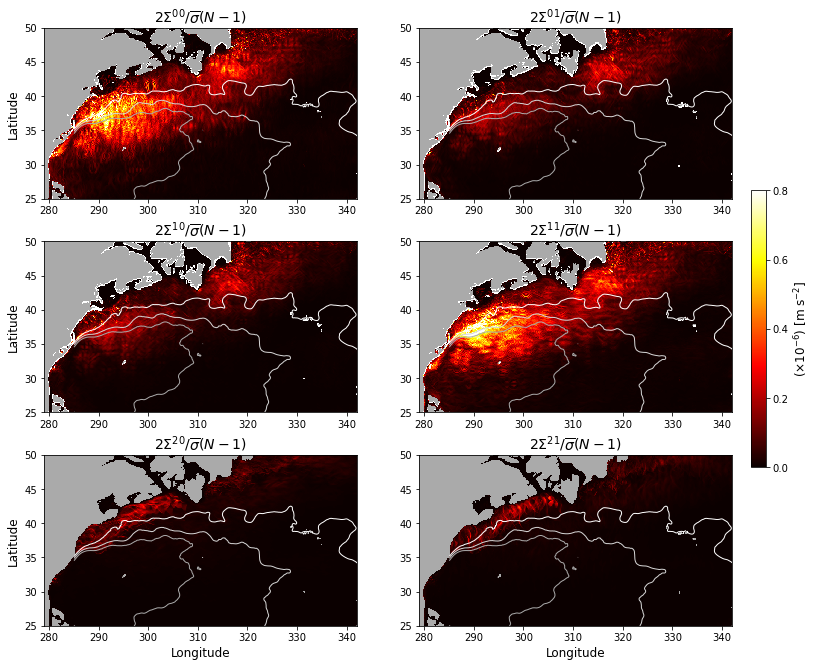

In [36]:
fig, axes = plt.subplots(figsize=(13,11), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(stdE00x.XC, stdE00x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                          2*stdE00x.sel(YC=slice(ySstart+5-12**-1,
                                                 yend+12**-1)).isel(delta_outer=nsig)*1e6, 
                          vmax=.8e0, vmin=0,
                          cmap='hot', rasterized=True)
axes[1,0].pcolormesh(stdE10y.XC, stdE10y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     2*stdE10y.sel(YC=slice(ySstart+5-12**-1,
                                            yend+12**-1)).isel(delta_outer=nsig)*1e6, 
                     vmax=.8e0, vmin=0,
                     cmap='hot', rasterized=True)
axes[0,1].pcolormesh(stdE01x.XC, stdE01x.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     2*stdE01x.sel(YC=slice(ySstart+5-12**-1,
                                            yend+12**-1)).isel(delta_outer=nsig)*1e6, 
                     vmax=.8e0, vmin=0,
                     cmap='hot', rasterized=True)
axes[1,1].pcolormesh(stdE11y.XC, stdE11y.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     2*stdE11y.sel(YC=slice(ySstart+5-12**-1,
                                            yend+12**-1)).isel(delta_outer=nsig)*1e6, 
                     vmax=.8e0, vmin=0,
                     cmap='hot', rasterized=True)
axes[2,0].pcolormesh(stdE20b.XC, stdE20b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     2*stdE20b.sel(YC=slice(ySstart+5-12**-1,
                                            yend+12**-1)).isel(delta_outer=nsig)*1e6, 
                     vmax=.8e0, vmin=0,
                     cmap='hot', rasterized=True)
axes[2,1].pcolormesh(stdE21b.XC, stdE21b.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     2*stdE21b.sel(YC=slice(ySstart+5-12**-1,
                                            yend+12**-1)).isel(delta_outer=nsig)*1e6, 
                     vmax=.8e0, vmin=0,
                     cmap='hot', rasterized=True)


cs00 = axes[0,0].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(delta_outer=nsig), 
                         levels=np.array([200,300,400,800]), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs00.collections:
    c.set_rasterized(True)
cs01 = axes[0,1].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(delta_outer=nsig), 
                         levels=np.array([200,300,400,800]), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs01.collections:
    c.set_rasterized(True)
cs10 = axes[1,0].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(delta_outer=nsig), 
                         levels=np.array([200,300,400,800]),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs10.collections:
    c.set_rasterized(True)
cs11 = axes[1,1].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(delta_outer=nsig), 
                         levels=np.array([200,300,400,800]), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs11.collections:
    c.set_rasterized(True)
cs20 = axes[2,0].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(delta_outer=nsig), 
                         levels=np.array([200,300,400,800]), 
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs20.collections:
    c.set_rasterized(True)
cs21 = axes[2,1].contour(zetab.XC.sel(XC=slice(285,None)), zetab.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                         -zetab.where(zetab<-100.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1),
                                                       XC=slice(285,None)).isel(delta_outer=nsig), 
                         levels=np.array([200,300,400,800]),
                         cmap='binary',
#                          colors='k',
                         linewidths=1)
for c in cs21.collections:
    c.set_rasterized(True)

    

axes[0,0].pcolormesh(ds5.XC, ds5.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(ds5.XC, ds5.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(ds5.XC, ds5.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask, ~mask), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(ds5.XC, ds5.YC.sel(YC=slice(ySstart+5-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask, ~mask),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(ds5.XC, ds5.YC.sel(YC=slice(yNstart-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask20, ~mask20), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(ds5.XC, ds5.YC.sel(YC=slice(yNstart-12**-1,yend+12**-1)), 
                     np.ma.masked_array(mask21, ~mask21),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)



axes[0,0].set_title(r"$2\Sigma^{00}/\overline{\sigma}(N-1)$", 
                    fontsize=14)
axes[1,0].set_title(r"$2\Sigma^{10}/\overline{\sigma}(N-1)$", 
                    fontsize=14)
axes[0,1].set_title(r"$2\Sigma^{01}/\overline{\sigma}(N-1)$", 
                    fontsize=14)
axes[1,1].set_title(r"$2\Sigma^{11}/\overline{\sigma}(N-1)$", 
                    fontsize=14)
axes[2,0].set_title(r"$2\Sigma^{20}/\overline{\sigma}(N-1)$", 
                    fontsize=14)
axes[2,1].set_title(r"$2\Sigma^{21}/\overline{\sigma}(N-1)$", 
                    fontsize=14)


axes[2,0].set_xlabel(r"Longitude", fontsize=12)
axes[2,1].set_xlabel(r"Longitude", fontsize=12)
axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)


axes[0,0].set_ylim([25,50])
axes[0,1].set_ylim([25,50])
axes[1,0].set_ylim([25,50])
axes[1,1].set_ylim([25,50])
axes[2,0].set_ylim([25,50])
axes[2,1].set_ylim([25,50])
axes[0,0].set_xlim([279,342])
axes[0,1].set_xlim([279,342])
axes[1,0].set_xlim([279,342])
axes[1,1].set_xlim([279,342])
axes[2,0].set_xlim([279,342])
axes[2,1].set_xlim([279,342])

fig.subplots_adjust(right=0.86, hspace=.25)
cbaxes = fig.add_axes([0.88, 0.325, 0.016, 0.35]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
                    ticks=[0.,.2,.4,.6,.8])
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"$(\times 10^{-6})$ [m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/stdDivE-P_%2dmembs_flux_5Dave-delta_isig%02d_1967-Jan-03.pdf' 
                    % (len(nmembs),nsig))
           )